In [11]:
from sotodlib import core, io

import datetime as dt

import numpy as np
import dill as pk

import h5py
from optical_loading import pwv_interp


In [12]:
pwv = pwv_interp()

In [13]:
with open("results_05012025.pk", "rb") as f:
    result_dict = pk.load(f)
    
with open("abscals.pk", "rb") as f:
    abscal_dict = pk.load(f)


In [14]:
ctx = core.Context('./smurf_det_preproc.yaml')

start = dt.datetime(2025,4,17, tzinfo=dt.timezone.utc)
end = dt.datetime(2025,4,28, tzinfo=dt.timezone.utc)
obs_list = ctx.obsdb.query(
    f"{end.timestamp()} > timestamp and timestamp > {start.timestamp()} and type=='obs' and subtype=='cmb'"
)

In [159]:
net_dict = {}

for key in abscal_dict.keys():
    ufm = key.split("_")[4]
    freq = key.split("_")[5]
    if ufm in abscal_dict.keys():
        continue
    if "090" in freq or "150" in freq:
        net_dict[ufm] = {"090":{"chi":[], "obs":[], "ndets":[], "nets":[], "raw_cal":[], "el":[], "pwv":[]}, "150":{"chi":[], "obs":[], "ndets":[], "nets":[], "raw_cal":[], "el":[], "pwv":[]}}
    else:
        net_dict[ufm] = {"220":{"chi":[], "obs":[], "ndets":[], "nets":[], "raw_cal":[], "el":[], "pwv":[]}, "280":{"chi":[], "obs":[], "ndets":[], "nets":[], "raw_cal":[], "el":[], "pwv":[]}}

In [160]:
cur_obs = obs_list[1]
wafers = cur_obs["stream_ids_list"].split(",")
cur_wafer = wafers[0].split("_")[-1]

try:
    meta = ctx.get_meta(cur_obs["obs_id"])
except:
    print("No meta data for obs {}".format(cur_obs["obs_id"]))


In [164]:
wafer_flag = np.array([cur_wafer in ufm for ufm in meta.det_info.stream_id])


In [86]:
ufm_band = 1
if "mv" in cur_wafer:
    if ufm_band == 1:
        band = "090"
    elif ufm_band == 2:
        band = "150"
if "uv" in cur_wafer:
    if ufm_band == 1:
        band = "220"
    elif ufm_band == 2:
        band = "280"


wafer_flag = np.array([cur_wafer in ufm for ufm in meta.det_info.stream_id])

bp = (meta.det_cal.bg % 4) // 2

if ufm_band == 1:
    net_flag = wafer_flag * (bp==0)
elif ufm_band == 2:
    net_flag = wafer_flag * (bp==1)

try:
    times = np.array([float(label.split("_")[0]) for label in result_dict[cur_wafer][band]["obs"]])
except KeyError:
    continue
    
closest_idx = np.argmin(np.abs(times-cur_obs["timestamp"]))
closest_obs = times[closest_idx]
closest_chi = result_dict[cur_wafer][band]["chi"][closest_idx]
if np.abs(times[5]-cur_obs["timestamp"])/3600 < 24 and 25 <= closest_chi and closest_chi < 1000 : #If most recent obs within a day
    raw_cal = result_dict[cur_wafer][band]["raw_cal"][closest_idx]
    chisq = closest_chi
else:
    raw_cal = np.mean(result_dict[cur_wafer][band]["raw_cal"])
    chisq = 999999
ndets = len(np.where((meta.preprocess.noise.white_noise[net_flag] != 0))[0])

net_mes = 1/np.sqrt(2) * meta.preprocess.noise.white_noise[net_flag] * raw_cal * meta.det_cal.phase_to_pW[net_flag]
clean_nets = []
for net in net_mes:
    if net*1e6 >= 125:
        clean_nets.append(net)
clean_nets = np.array(clean_nets)
array_net = np.nansum((clean_nets*1e6)**(-2))**(-1/2)

In [87]:
net_dict[cur_wafer][band]["raw_cal"].append(raw_cal)
net_dict[cur_wafer][band]["chi"].append(chisq)
net_dict[cur_wafer][band]["obs"].append(cur_obs["obs_id"])
net_dict[cur_wafer][band]["ndets"].append(ndets)
net_dict[cur_wafer][band]["nets"].append(array_net)
net_dict[cur_wafer][band]["el"].append(result_dict[cur_wafer][band]["el"])
net_dict[cur_wafer][band]["pwv"].append(result_dict[cur_wafer][band]["pwv"])

In [88]:
result_dict.keys()

dict_keys(['uv47', 'uv31', 'uv39', 'uv38', 'mv13', 'mv20', 'mv14', 'mv49', 'mv25', 'mv21', 'mv24'])

# Plotting

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sotodlib import core, io

import datetime as dt

import numpy as np
import dill as pk

import h5py
from optical_loading import pwv_interp

pwv = pwv_interp()
with open("results_05012025.pk", "rb") as f:
    result_dict = pk.load(f)
    
with open("nets.pk", "rb") as f:
    net_dict = pk.load(f)

/so/home/jorlo/venvs/sotodlib/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
labels = []
nets = []
chis = []
obs = []
pwvs = []
ndets = []
neps = []
neis = []
cals = []
els = []

freqs = ["090", "150", "220", "280"]
ufms = sorted(result_dict.keys())

for freq in freqs: #This is slighly inefficient but the ezest way to sort by freq then ufm
    for ufm in ufms:
        for key in net_dict.keys():
            if ufm not in key:
                continue
            for sub_key in net_dict[key].keys():
                if freq not in sub_key:
                    continue
                cur_chis = np.array(net_dict[key][sub_key]["chi"])
                #flags = np.where((25<= cur_chis) & (cur_chis<=1000))[0]
                cur_nets = np.array(net_dict[key][sub_key]["nets"])
                #cur_chis = cur_chis[flags]
                cur_obs = np.array(net_dict[key][sub_key]["obs"])
                cur_ndets = np.array(net_dict[key][sub_key]["ndets"])
                cur_abscals = np.array(net_dict[key][sub_key]["raw_cal"])
                cur_neis =net_dict[key][sub_key]["neps"]
                cur_el = np.array(net_dict[key][sub_key]["el"])

                label = str(freq)+"_"+str(ufm)
                for j in range(len(cur_nets)):
                    cur_pwv = pwv(cur_obs[j].split("_")[1])
                    if cur_nets[j] <= 100 and cur_ndets[j] > 100 and cur_pwv < 3: #very large nets are not real
                        nets.append(cur_nets[j])
                        labels.append(label)
                        chis.append(cur_chis[j])
                        obs.append(cur_obs[j])
                        pwvs.append(cur_pwv)
                        ndets.append(cur_ndets[j])
                        neps.append(cur_nets[j]/cur_abscals[j]*np.sqrt(2)*np.sqrt(cur_ndets[j]))
                        cals.append(cur_abscals[j])
                        els.append(cur_el[j])
                        for nei in cur_neis[j]:
                            neis.append(nei)
                    
labels = np.array(labels)
nets = np.array(nets)
chis = np.array(chis)
obs = np.array(obs)
pwvs = np.array(pwvs)
ndets = np.array(ndets)
neps = np.array(neps)
neis = np.array(neis)
cals = np.array(cals)
els = np.array(els)

df = pd.DataFrame({'labels': labels, 'nets': nets, 'chis': chis, 'obs': obs, "ndets":ndets, "pwv":pwvs, "neps":neps, "cals":cals, "el":els})

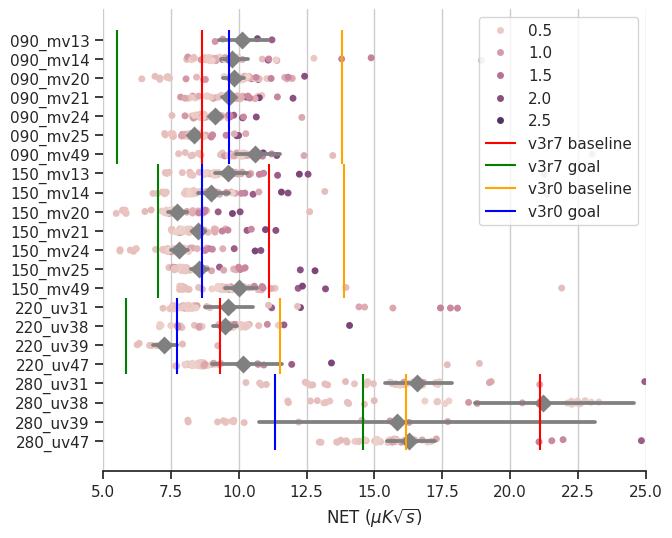

In [10]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))

# Add in points to show each observation
sns.pointplot(data=df, x="nets", y="labels", linestyle="none", marker="D", color="0.5", zorder=2)
sns.stripplot(df, x="nets", y="labels", hue="pwv", zorder=1)



ymax, ymin = ax.get_ylim()
#090 Goals
plt.vlines(2.70*np.sqrt(12)/1.08, ymin = ymin, ymax = 6.5, label="v3r7 baseline", color="red")
plt.vlines(1.72*np.sqrt(12)/1.08, ymin = ymin, ymax = 6.5, label="v3r7 goal", color="green")

plt.vlines(4.31*np.sqrt(12)/1.08, ymin = ymin, ymax = 6.5, label="v3r0 baseline", color="orange")
plt.vlines(3.01*np.sqrt(12)/1.08, ymin = ymin, ymax = 6.5, label="v3r0 goal", color="blue")

#150 Goals
plt.vlines(3.21*np.sqrt(12)/1.0, ymin = 6.5, ymax = 13.5, label=None, color="red")
plt.vlines(2.03*np.sqrt(12)/1.0, ymin = 6.5, ymax = 13.5, label=None, color="green")

plt.vlines(4.01*np.sqrt(12)/1.0, ymin = 6.5, ymax = 13.5, label=None, color="orange")
plt.vlines(2.50*np.sqrt(12)/1.0, ymin = 6.5, ymax = 13.5, label=None, color="blue")

#220 Goals
plt.vlines(3.84*np.sqrt(6)/1.01, ymin = 13.5, ymax = 17.5, label=None, color="red")
plt.vlines(2.41*np.sqrt(6)/1.01, ymin = 13.5, ymax = 17.5, label=None, color="green")

plt.vlines(4.71*np.sqrt(6)/1.0, ymin = 13.5, ymax = 17.5, label=None, color="orange")
plt.vlines(3.16*np.sqrt(6)/1.0, ymin = 13.5, ymax = 17.5, label=None, color="blue")

#280 Goals
plt.vlines(8.61*np.sqrt(6)/1.0, ymin = 17.5, ymax = ymax, label=None, color="red")
plt.vlines(5.95*np.sqrt(6)/1.0, ymin = 17.5, ymax = ymax, label=None, color="green")

plt.vlines(6.60*np.sqrt(6)/1.0, ymin = 17.5, ymax = ymax, label=None, color="orange")
plt.vlines(4.63*np.sqrt(6)/1.0, ymin = 17.5, ymax = ymax, label=None, color="blue")


plt.xlim(5, 25)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(xlabel="NET ($\mu K \sqrt{s}$)", ylabel="")
sns.despine(trim=True, left=True)

plt.legend()
f.savefig("./plts/nets/nets.pdf", dpi=600, bbox_inches='tight')
f.savefig("./plts/nets/nets.png", dpi=600, bbox_inches='tight')

## NEPs

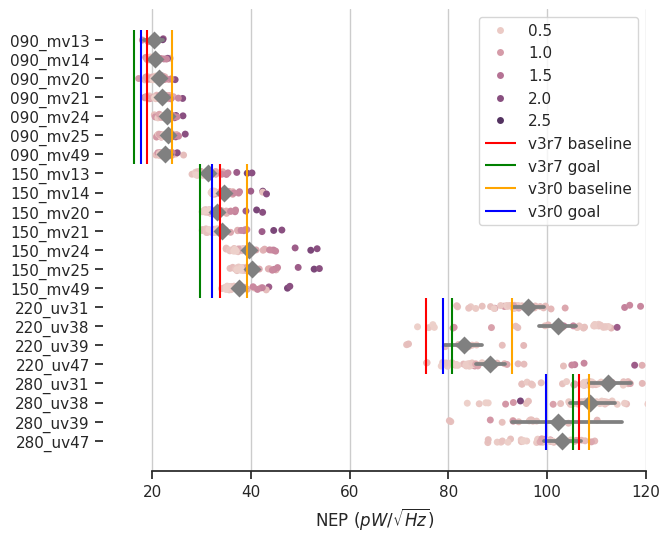

In [9]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))

# Add in points to show each observation
sns.pointplot(data=df, x="neps", y="labels", linestyle="none", marker="D", color="0.5", zorder=2)
sns.stripplot(df, x="neps", y="labels", hue="pwv", zorder=1)



ymax, ymin = ax.get_ylim()
#90 Goals
plt.vlines(18.99, ymin = ymin, ymax = 6.5, label="v3r7 baseline", color="red")
plt.vlines(16.37, ymin = ymin, ymax = 6.5, label="v3r7 goal", color="green")

plt.vlines(24.04, ymin = ymin, ymax = 6.5, label="v3r0 baseline", color="orange")
plt.vlines(17.70, ymin = ymin, ymax = 6.5, label="v3r0 goal", color="blue")

#150 Goals
plt.vlines(33.81, ymin = 6.5, ymax = 13.5, label=None, color="red")
plt.vlines(29.72, ymin = 6.5, ymax = 13.5, label=None, color="green")

plt.vlines(39.25, ymin = 6.5, ymax = 13.5, label=None, color="orange")
plt.vlines(32.13, ymin = 6.5, ymax = 13.5, label=None, color="blue")

#220 Goals
plt.vlines(75.43, ymin = 13.5, ymax = 17.5, label=None, color="red")
plt.vlines(80.83, ymin = 13.5, ymax = 17.5, label=None, color="green")

plt.vlines(92.86, ymin = 13.5, ymax = 17.5, label=None, color="orange")
plt.vlines(78.89, ymin = 13.5, ymax = 17.5, label=None, color="blue")

#280 Goals
plt.vlines(106.56, ymin = 17.5, ymax = ymax, label=None, color="red")
plt.vlines(105.25, ymin = 17.5, ymax = ymax, label=None, color="green")

plt.vlines(108.63, ymin = 17.5, ymax = ymax, label=None, color="orange")
plt.vlines(99.79, ymin = 17.5, ymax = ymax, label=None, color="blue")


plt.xlim(10, 120)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(xlabel="NEP ($pW / \sqrt{Hz}$)", ylabel="")
sns.despine(trim=True, left=True)

plt.legend()
f.savefig("./plts/nets/neps_mf.pdf", dpi=600, bbox_inches='tight')
f.savefig("./plts/nets/neps_mf.png", dpi=600, bbox_inches='tight')

In [120]:
if False:
    ctx = core.Context('./smurf_det_preproc.yaml')


    obs_list = ctx.obsdb.query(
        f"timestamp > 1723783842 and timestamp < 1723900000 and type=='obs'"
    )
    neps_snork_090 = []
    neps_snork_150 = []

    for obs in obs_list:
        meta = ctx.get_meta(obs_list[9]["obs_id"]) 

        for i in [0,1]:
            bp = (meta.det_cal.bg % 4) // 2
            net_flag = (bp==i)

            cur_neps = meta.preprocess.noise.white_noise[net_flag] * meta.det_cal.phase_to_pW[net_flag]

            if i == 0:
                for j in range(len(cur_neps)):
                    if neps[j] == np.nan: 
                        continue
                    neps_snork_090.append(cur_neps[j])

            else:
                for j in range(len(cur_neps)):
                    if neps[j] == np.nan: 
                            continue
                    neps_snork_150.append(cur_neps[j])            


    neps_snork_090 = np.array(neps_snork_090)
    neps_snork_150 = np.array(neps_snork_150)
    baseline = 18.99

    plt.hist(neps_snork_090*1e6/baseline, bins = np.linspace(0,2, 20))

In [121]:
nep_labels = []
neps = []
cals = []
neis = []
obs = []

freqs = ["090", "150", "220", "280"]
ufms = sorted(result_dict.keys())

for freq in freqs: #This is slighly inefficient but the ezest way to sort by freq then ufm
    for ufm in ufms:
        for key in net_dict.keys():
            if ufm not in key:
                continue
            for sub_key in net_dict[key].keys():
                if freq not in sub_key:
                    continue
                cur_abscals = np.array(net_dict[key][sub_key]["raw_cal"])
                cur_nets = np.array(net_dict[key][sub_key]["nets"])
                cur_neps =net_dict[key][sub_key]["neps"]
                cur_obs = np.array(net_dict[key][sub_key]["obs"])
                cur_ndets = np.array(net_dict[key][sub_key]["ndets"])
                cur_phicals = net_dict[key][sub_key]["phiconv"]
                label = str(freq)+"_"+str(ufm)
                for j in range(len(cur_abscals)):
                    cur_pwv = pwv(cur_obs[j].split("_")[1])
                    if cur_nets[j] <= 100 and cur_ndets[j] > 100 and cur_pwv < 3: #very large nets are not real
                        for i, nep in enumerate(cur_neps[j]): 
                            neps.append(nep)
                            nep_labels.append(label)
                            cals.append(cur_phicals[j][i])
                            neis.append(nep/cur_phicals[j][i] * 9e6/(2 * np.pi))
                            obs.append(cur_obs[j])
                    
labels = np.array(labels)
neps = np.array(neps)
neis = np.array(neis)
obs = np.array(obs)
cals = np.array(cals)

/tmp/ipykernel_6061/2056628077.py:32: RuntimeWarning: invalid value encountered in scalar divide
  neis.append(nep/cur_phicals[j][i] * 9e6/(2 * np.pi))


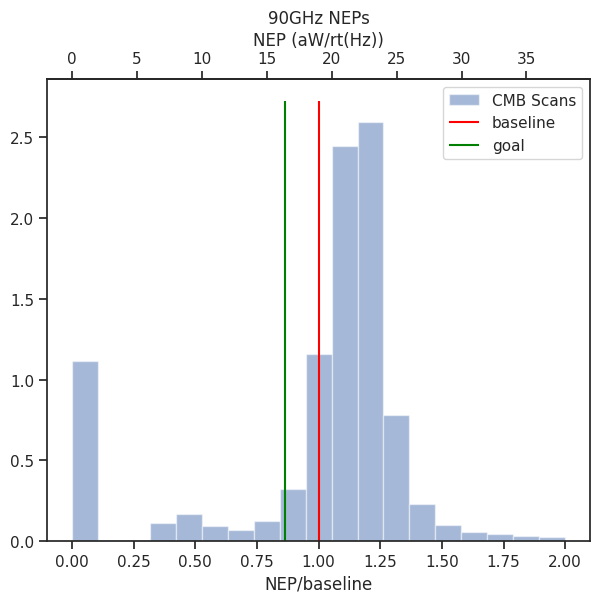

In [122]:
f, ax = plt.subplots(figsize=(7, 6))
flags = np.where(np.char.find(nep_labels, "090") != -1)[0]

baseline = 18.99

plt.hist(neps[flags]*1e6/baseline, bins = np.linspace(0,2, 20), label = "CMB Scans", density = True, alpha = 0.5)
#plt.hist(neps_snork_090*1e6/baseline, bins = np.linspace(0,2, 20), label = "Snorkel Stare", density = True, alpha = 0.5)
ymax, ymin = ax.get_ylim()
plt.vlines(1, ymin, ymax, label="baseline", color="red")
plt.vlines(16.37/baseline, ymin, ymax, label="goal", color="green")
plt.xlabel("NEP/baseline")
plt.title("90GHz NEPs")
plt.legend()

def normalize(x):
    return x / baseline
def denorm(x):
    return x * baseline

secax = ax.secondary_xaxis("top", functions=(denorm, normalize))
secax.set_xlabel("NEP (aW/rt(Hz))")

f.savefig("./plts/nets/neps_090.pdf", dpi=600, bbox_inches='tight')
f.savefig("./plts/nets/neps_090.png", dpi=600, bbox_inches='tight')

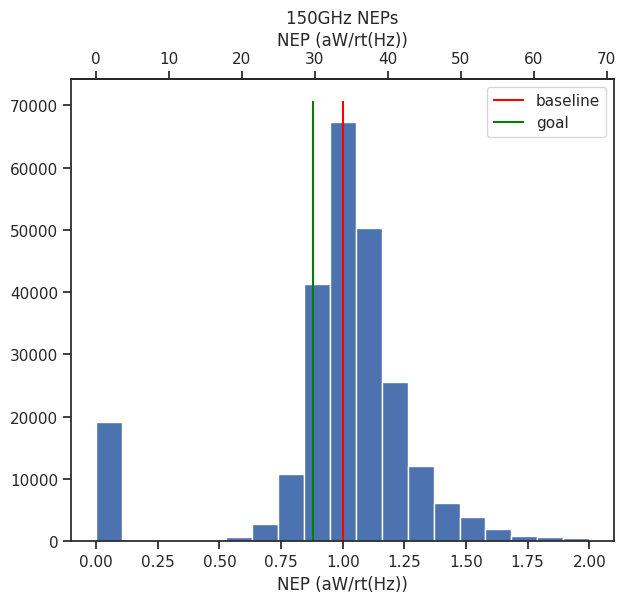

In [85]:
f, ax = plt.subplots(figsize=(7, 6))
flags = np.where(np.char.find(nep_labels, "150") != -1)[0]

baseline = 33.81

plt.hist(neps[flags]*1e6/baseline, bins = np.linspace(0,2, 20))
ymax, ymin = ax.get_ylim()
plt.vlines(1, ymin, ymax, label="baseline", color="red")
plt.vlines(29.72/baseline, ymin, ymax, label="goal", color="green")
plt.xlabel("NEP/baseline")
plt.title("150GHz NEPs")
plt.legend()

def normalize(x):
    return x / baseline
def denorm(x):
    return x * baseline

secax = ax.secondary_xaxis("top", functions=(denorm, normalize))
secax.set_xlabel("NEP (aW/rt(Hz))")

f.savefig("./plts/nets/neps_150.pdf", dpi=600, bbox_inches='tight')
f.savefig("./plts/nets/neps_150.png", dpi=600, bbox_inches='tight')

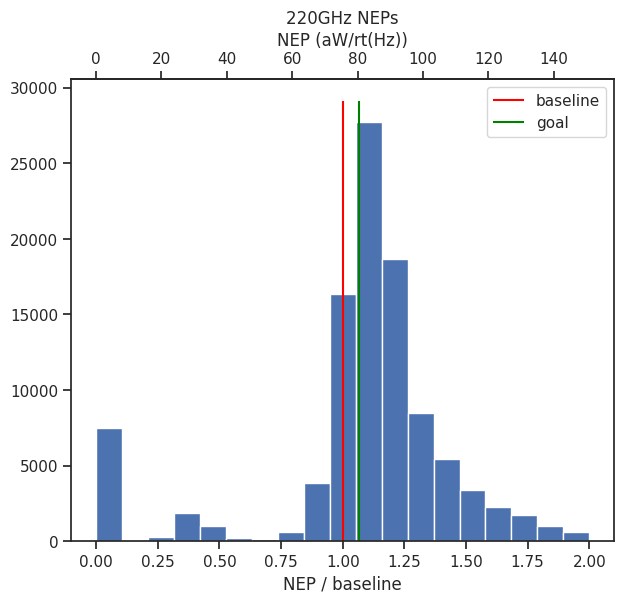

In [87]:
f, ax = plt.subplots(figsize=(7, 6))
flags = np.where(np.char.find(nep_labels, "220") != -1)[0]

baseline = 75.43

plt.hist(neps[flags]*1e6/baseline, bins = np.linspace(0,2, 20))
ymax, ymin = ax.get_ylim()
plt.vlines(1, ymin, ymax, label="baseline", color="red")
plt.vlines(80.56/baseline, ymin, ymax, label="goal", color="green")
plt.xlabel("NEP / baseline")
plt.title("220GHz NEPs")
plt.legend()

def normalize(x):
    return x / baseline
def denorm(x):
    return x * baseline

secax = ax.secondary_xaxis("top", functions=(denorm, normalize))
secax.set_xlabel("NEP (aW/rt(Hz))")

f.savefig("./plts/nets/neps_220.pdf", dpi=600, bbox_inches='tight')
f.savefig("./plts/nets/neps_220.png", dpi=600, bbox_inches='tight')

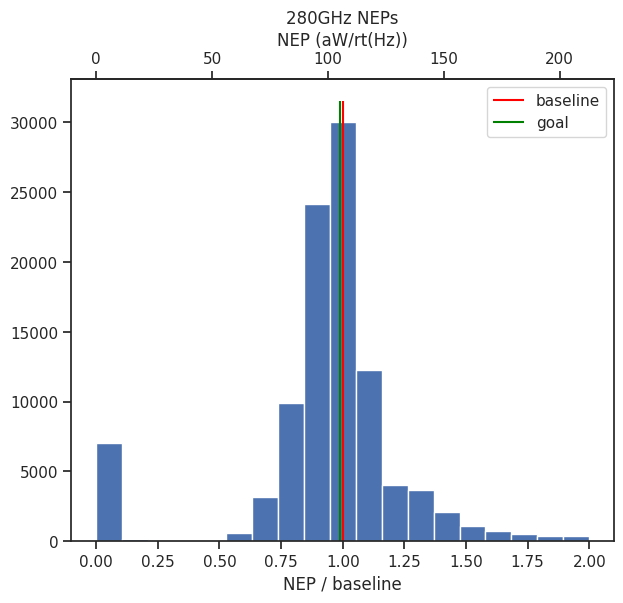

In [88]:
f, ax = plt.subplots(figsize=(7, 6))
flags = np.where(np.char.find(nep_labels, "280") != -1)[0]

baseline = 106.37

plt.hist(neps[flags]*1e6/baseline, bins = np.linspace(0,2, 20))
ymax, ymin = ax.get_ylim()
plt.vlines(1, ymin, ymax, label="baseline", color="red")
plt.vlines(105.25/baseline, ymin, ymax, label="goal", color="green")
plt.xlabel("NEP / baseline")
plt.title("280GHz NEPs")
plt.legend()

def normalize(x):
    return x / baseline
def denorm(x):
    return x * baseline

secax = ax.secondary_xaxis("top", functions=(denorm, normalize))
secax.set_xlabel("NEP (aW/rt(Hz))")

f.savefig("./plts/nets/neps_280.pdf", dpi=600, bbox_inches='tight')
f.savefig("./plts/nets/neps_280.png", dpi=600, bbox_inches='tight')

### NEP vs PWV

In [172]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
#f, ax = plt.subplots(figsize=(7, 6))

# Add in points to show each observation

mask = df['labels'].str.contains('090_mv14', case=False, na=False)

ymin = 0.95*np.amin(df[mask]["neps"])
ymax = 1.05*np.amax(df[mask]["neps"])


sns.lmplot(
    data=df[mask], x=df[mask].pwv / np.sin(np.deg2rad(df[mask].el)), y="neps"
)

plt.ylim(ymin, ymax)


# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(xlabel="pwv (mm)", ylabel="NEP ($pW / \sqrt{Hz}$)")
sns.despine(trim=True, left=True)

plt.legend()
#f.savefig("./plts/nets/neps_mf.pdf", dpi=600, bbox_inches='tight')
#f.savefig("./plts/nets/neps_mf.png", dpi=600, bbox_inches='tight')

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [166]:
df[mask].pwv / np.sin(df[mask].el)

4    -2.384222
5    -2.235529
6     0.755789
7     0.761491
8     0.750892
9     0.765619
10   -2.029413
11   -2.521748
12    0.930782
13    0.872697
14    0.815991
15    0.744975
16    0.786612
17   -3.573303
18    1.341275
19   -3.399594
20    2.392818
21    2.861137
22    0.823595
23   -2.032541
24    0.877802
25    0.627659
26   -1.564542
27    0.615209
28    0.615264
29    0.615264
30    0.626538
31    0.649087
32    0.603989
33    0.767510
34   -1.830907
35    0.682849
36    0.637813
37    0.633303
38    0.637813
39    0.636873
40    0.708466
41    1.048477
42   -2.913489
43    1.166000
44    2.665322
45    1.066147
46    1.104941
47    0.977751
48    1.046888
49    1.729590
50    1.665221
51    1.627419
52   -1.952899
53   -1.608328
54    0.547519
55    0.574248
dtype: float64

In [171]:
np.sin(np.deg2rad(df[mask].el))

4     0.766044
5     0.766012
6     0.642781
7     0.642782
8     0.642777
9     0.939682
10    0.866016
11    0.766046
12    0.642786
13    0.642789
14    0.642786
15    0.642786
16    0.642785
17    0.766046
18    0.939693
19    0.866027
20    0.642786
21    0.642789
22    0.939692
23    0.866025
24    0.642786
25    0.939692
26    0.866025
27    0.642788
28    0.642789
29    0.642789
30    0.642789
31    0.642789
32    0.642789
33    0.939692
34    0.866025
35    0.642788
36    0.642789
37    0.642789
38    0.642789
39    0.642789
40    0.642789
41    0.939692
42    0.866026
43    0.642786
44    0.642784
45    0.642788
46    0.642786
47    0.642786
48    0.642786
49    0.642788
50    0.642785
51    0.642786
52    0.766043
53    0.766043
54    0.642786
55    0.642788
Name: el, dtype: float64

# NEIs

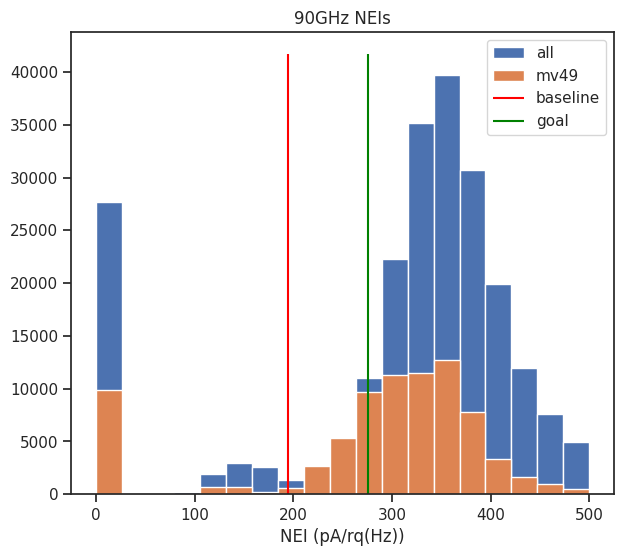

In [9]:
R_BOLO = 0.004 #From bolocalc https://github.com/simonsobs/bolocalc-so-model/blob/848ba3b6f611788b11b782a0a816a802c21fadbe/V3r7/V3r7_Goal/LAT/MF/config/channels.txt
P_SAT_base = 3.42
P_SAT_goal = 1.94 #https://github.com/simonsobs/bolocalc-so-model/blob/848ba3b6f611788b11b782a0a816a802c21fadbe/V3r7/V3r7_Goal/LAT/MF/config/channels.txt
P_OPT_base = 1.04 #https://github.com/simonsobs/bolocalc-so-model/blob/master/V3r7/V3r7_Baseline/LAT/MF/sensitivity.txt
P_OPT_goal = 1.06 

Si_base = 1/np.sqrt(R_BOLO * (P_SAT_base - P_OPT_base))
Si_goal = 1/np.sqrt(R_BOLO * (P_SAT_goal - P_OPT_goal))

f, ax = plt.subplots(figsize=(7, 6))
flags = np.where(np.char.find(nep_labels, "mv49") != -1)[0]
flags_090 = np.where(np.char.find(nep_labels, "090") != -1)[0]

plt.hist(neis[flags_090], bins = np.linspace(0,500, 20), label="all")
plt.hist(neis[flags], bins = np.linspace(0,500, 20), label="mv49")
ymax, ymin = ax.get_ylim()
plt.vlines(18.99*Si_base, ymin, ymax, label="baseline", color="red")
plt.vlines(16.37*Si_goal, ymin, ymax, label="goal", color="green")
plt.xlabel("NEI (pA/rq(Hz))")
plt.title("90GHz NEIs")
plt.legend()

f.savefig("./plts/nets/neis_090.pdf", dpi=600, bbox_inches='tight')
f.savefig("./plts/nets/neis_090.png", dpi=600, bbox_inches='tight')

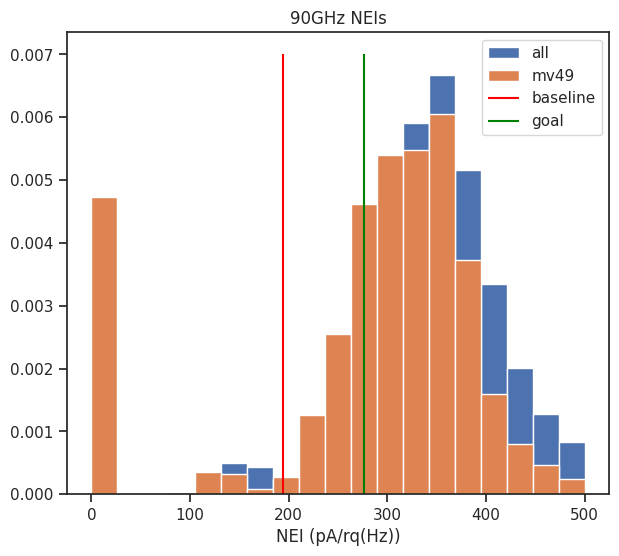

In [19]:
obs_set = np.unique(np.array(obs))


R_BOLO = 0.004 #From bolocalc https://github.com/simonsobs/bolocalc-so-model/blob/848ba3b6f611788b11b782a0a816a802c21fadbe/V3r7/V3r7_Goal/LAT/MF/config/channels.txt
P_SAT_base = 3.42
P_SAT_goal = 1.94 #https://github.com/simonsobs/bolocalc-so-model/blob/848ba3b6f611788b11b782a0a816a802c21fadbe/V3r7/V3r7_Goal/LAT/MF/config/channels.txt
P_OPT_base = 1.04 #https://github.com/simonsobs/bolocalc-so-model/blob/master/V3r7/V3r7_Baseline/LAT/MF/sensitivity.txt
P_OPT_goal = 1.06 

Si_base = 1/np.sqrt(R_BOLO * (P_SAT_base - P_OPT_base))
Si_goal = 1/np.sqrt(R_BOLO * (P_SAT_goal - P_OPT_goal))

f, ax = plt.subplots(figsize=(7, 6))
flags = np.where(np.char.find(nep_labels, "mv49") != -1)[0]
flags_090 = np.where(np.char.find(nep_labels, "090") != -1)[0]
plt.hist(neis[flags_090], bins = np.linspace(0,500, 20), label="all", density=True)
plt.hist(neis[flags], bins = np.linspace(0,500, 20), label="mv49", density=True)


ymax, ymin = ax.get_ylim()
plt.vlines(18.99*Si_base, ymin, ymax, label="baseline", color="red")
plt.vlines(16.37*Si_goal, ymin, ymax, label="goal", color="green")
plt.xlabel("NEI (pA/rq(Hz))")
plt.title("90GHz NEIs")
plt.legend()

f.savefig("./plts/nets/neis_090.pdf", dpi=600, bbox_inches='tight')
f.savefig("./plts/nets/neis_090.png", dpi=600, bbox_inches='tight')


In [42]:
times = np.zeros(len(obs_set))
for i in range(len(times)):
    times[i] = float(obs_set[i][4:14])
    
ys = np.zeros(len(times))
yerr = np.zeros(len(times))
for i in range(len(ys)):
    flags = np.where(np.char.find(obs, str(obs_set[i])) != -1)[0]
    ys[i] = np.nanmean(neis[flags])
    yerr = np.std(neis[flags])
    


<ErrorbarContainer object of 3 artists>

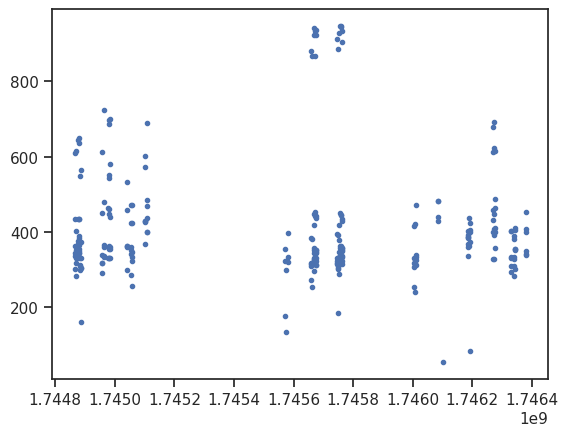

In [50]:
plt.errorbar(times, ys, yerr=np.sqrt(yerr), marker=".", ecolor='k', linestyle='')

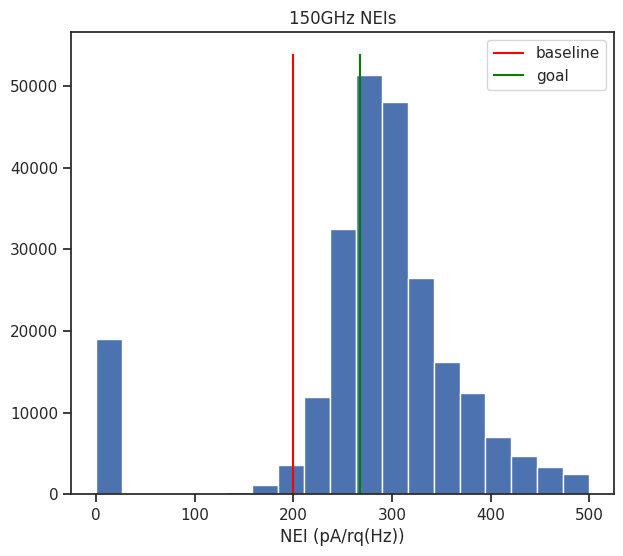

In [9]:
R_BOLO = 0.004 #From bolocalc https://github.com/simonsobs/bolocalc-so-model/blob/848ba3b6f611788b11b782a0a816a802c21fadbe/V3r7/V3r7_Goal/LAT/MF/config/channels.txt
P_SAT_base = 9.37
P_SAT_goal = 5.33 #https://github.com/simonsobs/bolocalc-so-model/blob/848ba3b6f611788b11b782a0a816a802c21fadbe/V3r7/V3r7_Goal/LAT/MF/config/channels.txt
P_OPT_base = 2.23 #https://github.com/simonsobs/bolocalc-so-model/blob/master/V3r7/V3r7_Baseline/LAT/MF/sensitivity.txt
P_OPT_goal = 2.25 

Si_base = 1/np.sqrt(R_BOLO * (P_SAT_base - P_OPT_base))
Si_goal = 1/np.sqrt(R_BOLO * (P_SAT_goal - P_OPT_goal))

f, ax = plt.subplots(figsize=(7, 6))
flags = np.where(np.char.find(nep_labels, "150") != -1)[0]

plt.hist(neis[flags], bins = np.linspace(0,500, 20))
ymax, ymin = ax.get_ylim()
plt.vlines(33.81*Si_base, ymin, ymax, label="baseline", color="red")
plt.vlines(29.72*Si_goal, ymin, ymax, label="goal", color="green")
plt.xlabel("NEI (pA/rq(Hz))")
plt.title("150GHz NEIs")
plt.legend()

f.savefig("./plts/nets/neis_150.pdf", dpi=600, bbox_inches='tight')
f.savefig("./plts/nets/neis_150.png", dpi=600, bbox_inches='tight')

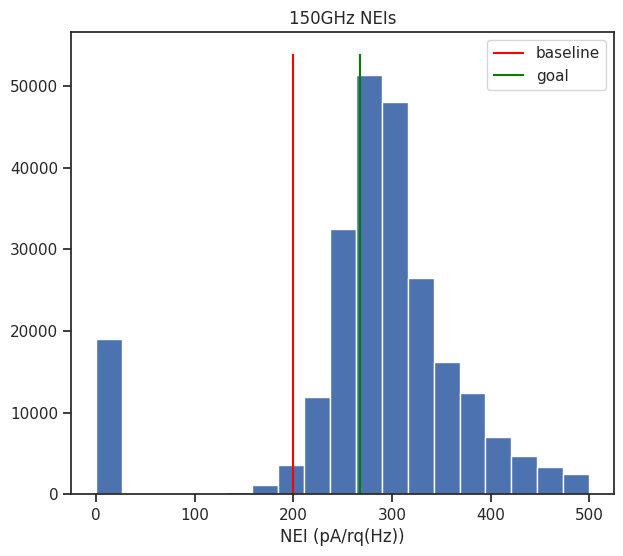

In [10]:
R_BOLO = 0.004 #From bolocalc https://github.com/simonsobs/bolocalc-so-model/blob/848ba3b6f611788b11b782a0a816a802c21fadbe/V3r7/V3r7_Goal/LAT/MF/config/channels.txt
P_SAT_base = 9.37
P_SAT_goal = 5.33 #https://github.com/simonsobs/bolocalc-so-model/blob/848ba3b6f611788b11b782a0a816a802c21fadbe/V3r7/V3r7_Goal/LAT/MF/config/channels.txt
P_OPT_base = 2.23 #https://github.com/simonsobs/bolocalc-so-model/blob/master/V3r7/V3r7_Baseline/LAT/MF/sensitivity.txt
P_OPT_goal = 2.25 

Si_base = 1/np.sqrt(R_BOLO * (P_SAT_base - P_OPT_base))
Si_goal = 1/np.sqrt(R_BOLO * (P_SAT_goal - P_OPT_goal))

f, ax = plt.subplots(figsize=(7, 6))
flags = np.where(np.char.find(nep_labels, "150") != -1)[0]

plt.hist(neis[flags], bins = np.linspace(0,500, 20))
ymax, ymin = ax.get_ylim()
plt.vlines(33.81*Si_base, ymin, ymax, label="baseline", color="red")
plt.vlines(29.72*Si_goal, ymin, ymax, label="goal", color="green")
plt.xlabel("NEI (pA/rq(Hz))")
plt.title("150GHz NEIs")
plt.legend()

f.savefig("./plts/nets/neis_150.pdf", dpi=600, bbox_inches='tight')
f.savefig("./plts/nets/neis_150.png", dpi=600, bbox_inches='tight')